# Import libraries :open_file_folder:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
import random

import warnings
import json

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, f1_score

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Ignore WARNINGS :warning:

In [2]:
warnings.filterwarnings('ignore')

# Read CSV file :scroll: and some edits :pencil:

In [3]:
df = pd.read_csv("../../src/sigma0.csv")
df = df.drop(['address', 'longitude', 'latitude', 'uid', 'center_lat', 'center_lon', 'floor', 'metro_name', 'metro_dist_km'], axis=1)
# df['isBigcity'] = df.city.apply(lambda v: True if v in ['Москва', 'Санкт-Петербург'] else False)
df = df[df.price < 32_000_000]
df['total_floors'][15785] = 17
# df.price = np.log1p(df['price'])
# df['predicted_price'] = df.area * df.city_flat_mean_squared_price
# df = df[df.city == "Новосибирск"]
# df = df[df.isBigcity == False]
df = df.drop_duplicates()

df = df.drop(['city_flat_mean_price', 'city_flat_mean_area', 'city_flat_center_distance', 'city_flat_mean_squared_price'], axis=1)
df

,city,price,area,kitchen_area,total_rooms,total_floors,build_date,material_type,remont,total_balcony,distance_to_center
0,Анапа,10952600.0,46.00,23.1,2.0,8.0,empty,monolith,fine,1,10.867409
1,Анапа,16890000.0,91.50,16.8,2.0,14.0,empty,empty,empty,2,1.298667
2,Анапа,9649380.0,41.70,18.3,1.0,8.0,empty,monolith,fine,1,10.806230
3,Анапа,8700000.0,56.00,25.0,2.0,13.0,empty,monolith,empty,0,2.788732
4,Анапа,15300000.0,68.92,empty,2.0,7.0,empty,monolith,empty,empty,3.920082
...,...,...,...,...,...,...,...,...,...,...,...
39143,Санкт-Петербург,13490000.0,93.00,18.6,4.0,18.0,2015.0,monolith,standard,1.0,12.983655
39145,Санкт-Петербург,26799000.0,95.30,19.06,4.0,25.0,2016.0,monolith,design,1.0,13.524419
39151,Санкт-Петербург,6500000.0,48.50,9.7,4.0,5.0,1960.0,panel,standard,1.0,8.512609
39153,Санкт-Петербург,30000000.0,110.00,22.0,4.0,25.0,2012.0,brick_monolith,well_done,1.0,12.379187


In [4]:
for column in df.columns:
    print(column)
    for value in ['0.0', '0', 0, 0.0, 'empty']:
        print(value, "-->", len(df[df[column] == value]))
    print("NaN -->", df[column].isna().sum())
    print()

city
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

price
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

area
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

kitchen_area
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 4151
NaN --> 0

total_rooms
0.0 --> 0
0 --> 0
0 --> 1638
0.0 --> 1638
empty --> 0
NaN --> 0

total_floors
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0

build_date
0.0 --> 211
0 --> 0
0 --> 73
0.0 --> 73
empty --> 9184
NaN --> 2678

material_type
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 1906
NaN --> 0

remont
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 12195
NaN --> 0

total_balcony
0.0 --> 0
0 --> 1971
0 --> 0
0.0 --> 0
empty --> 8804
NaN --> 0

distance_to_center
0.0 --> 0
0 --> 0
0 --> 0
0.0 --> 0
empty --> 0
NaN --> 0



# Temporary!!! Drop NaN build years :x:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34044 entries, 0 to 39155
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34044 non-null  object 
 1   price               34044 non-null  float64
 2   area                34044 non-null  float64
 3   kitchen_area        34044 non-null  object 
 4   total_rooms         34044 non-null  float64
 5   total_floors        34044 non-null  float64
 6   build_date          31366 non-null  object 
 7   material_type       34044 non-null  object 
 8   remont              34044 non-null  object 
 9   total_balcony       34044 non-null  object 
 10  distance_to_center  34044 non-null  float64
dtypes: float64(5), object(6)
memory usage: 3.1+ MB


In [6]:
df = df[df.build_date.notna()]
df = df[df.build_date != 'empty']
df = df[~df.build_date.isin((0, 0.0, '0', '0.0'))]

# Drop Anomalies :x:

In [7]:
df = df[df.distance_to_center < 200]

# Fix kitchen values :wrench:

In [9]:
df2 = df[df.kitchen_area != 'empty']
df3 = df[df.kitchen_area == 'empty']

i = 0
for value in df3.kitchen_area:
    if value == 'empty':
        df3.kitchen_area.iloc[i] = df3.area.iloc[i] * 0.2
    i += 1
    print(ceil((100 * i)/len(df3.kitchen_area)), end='\r')

In [10]:
df = pd.concat([df2, df3], ignore_index=True)
df

,city,price,area,kitchen_area,total_rooms,total_floors,build_date,material_type,remont,total_balcony,distance_to_center
0,Анапа,5658000.0,77.0,8.0,2.0,10.0,2013,monolith,empty,0,1.987605
1,Анапа,7700000.0,56.1,28.0,1.0,21.0,2018,monolith,empty,0,2.900801
2,Анапа,7700000.0,67.7,10.7,3.0,5.0,2008,monolithBrick,empty,1,3.611164
3,Анапа,5800000.0,37.8,10.1,1.0,16.0,2017,block,empty,1,3.331211
4,Анапа,6500000.0,40.4,10.0,1.0,6.0,2010,monolith,empty,0,1.046543
...,...,...,...,...,...,...,...,...,...,...,...
21823,Санкт-Петербург,16960000.0,61.3,12.26,2.0,4.0,1897,brick,empty,empty,3.103760
21824,Санкт-Петербург,19900000.0,107.7,21.54,4.0,6.0,1898,brick,empty,empty,2.712180
21825,Санкт-Петербург,26990000.0,75.0,15.0,3.0,13.0,2021,empty,empty,empty,5.820422
21826,Санкт-Петербург,30000000.0,80.0,16.0,2.0,6.0,1917,brick,empty,0,1.818523


In [11]:
df.kitchen_area.value_counts()

kitchen_area
6.0                  522
10.0                 468
9.0                  426
8.0                  425
12.0                 334
                    ... 
6.188000000000001      1
17.554                 1
6.136                  1
6.164000000000001      1
11.54                  1
Name: count, Length: 2274, dtype: int64

# Fix total_balcony data :wrench:

In [12]:
df.loc[df['total_balcony'] == '1.0', 'total_balcony'] = '1'
df.loc[df['total_balcony'] == '2.0', 'total_balcony'] = '2'
df.loc[df['total_balcony'] == 1.0, 'total_balcony'] = '1'
df.loc[df['total_balcony'] == 2.0, 'total_balcony'] = '2'
df.loc[df['total_balcony'] == 'empty', 'total_balcony'] = '1'

In [13]:
df.total_balcony.value_counts()

total_balcony
1    18556
2     1776
0     1490
3        4
4        2
Name: count, dtype: int64

# Fix material_type data :wrench:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  object 
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  float64
 6   build_date          21828 non-null  object 
 7   material_type       21828 non-null  object 
 8   remont              21828 non-null  object 
 9   total_balcony       21828 non-null  object 
 10  distance_to_center  21828 non-null  float64
dtypes: float64(5), object(6)
memory usage: 1.8+ MB


In [15]:
df.loc[df['material_type'] == 'brick', 'material_type'] = 'Кирпичный'
df.loc[df['material_type'] == 'Кирпичный', 'material_type'] = 'Кирпичный'

df.loc[df['material_type'] == 'Железобетонный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'monolith', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Монолитный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Смешанный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'Бетонный', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == '0', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == '0.0', 'material_type'] = 'Монолитный'
df.loc[df['material_type'] == 'empty', 'material_type'] = 'Монолитный'

df.loc[df['material_type'] == 'panel', 'material_type'] = 'Панельный'

df.loc[df['material_type'] == 'block', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'Блочный', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'foamConcreteBlock', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'aerocreteBlock', 'material_type'] = 'Блочный'
df.loc[df['material_type'] == 'gasSilicateBlock', 'material_type'] = 'Блочный'

df.loc[df['material_type'] == 'wood', 'material_type'] = 'Деревянный'
df.loc[df['material_type'] == 'Деревянный', 'material_type'] = 'Деревянный'

df.loc[df['material_type'] == 'monolithBrick', 'material_type'] = 'Монолитно-кирпичный'
df.loc[df['material_type'] == 'brick_monolith', 'material_type'] = 'Монолитно-кирпичный'

df.loc[df['material_type'] == 'stalin', 'material_type'] = 'Сталинский'

df.loc[df['material_type'] == 'old', 'material_type'] = 'Старый фонд'

df = df[df.material_type != 'Иное']

In [16]:
df.material_type.value_counts()

material_type
Монолитный             7558
Панельный              6583
Кирпичный              5359
Монолитно-кирпичный    1361
Блочный                 934
Старый фонд              16
Деревянный               10
Сталинский                7
Name: count, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  object 
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  float64
 6   build_date          21828 non-null  object 
 7   material_type       21828 non-null  object 
 8   remont              21828 non-null  object 
 9   total_balcony       21828 non-null  object 
 10  distance_to_center  21828 non-null  float64
dtypes: float64(5), object(6)
memory usage: 1.8+ MB


# Exploratory Data Analysis (EDA) :gem: :mag:

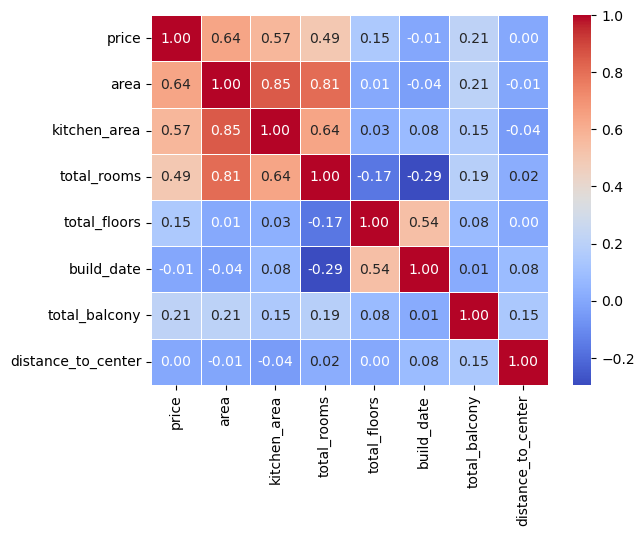

In [18]:
df_heatmap = df.drop(['city', 'material_type', 'remont'], axis=1)
plt.figure()
sns.heatmap(df_heatmap.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.show()

In [19]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    print("##########################################")
    
    if plot:
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df["ratio"]) 
        plt.xlabel("Features")
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Feature")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}%", ha="center", va="bottom", fontsize=8, rotation=90) 
        
        plt.xticks(rotation=90, fontsize=8) 
        plt.yticks(fontsize=8) 
        plt.grid(True)  
        plt.tight_layout()
        plt.show()

    if na_name:
        return na_columns

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
##########################################


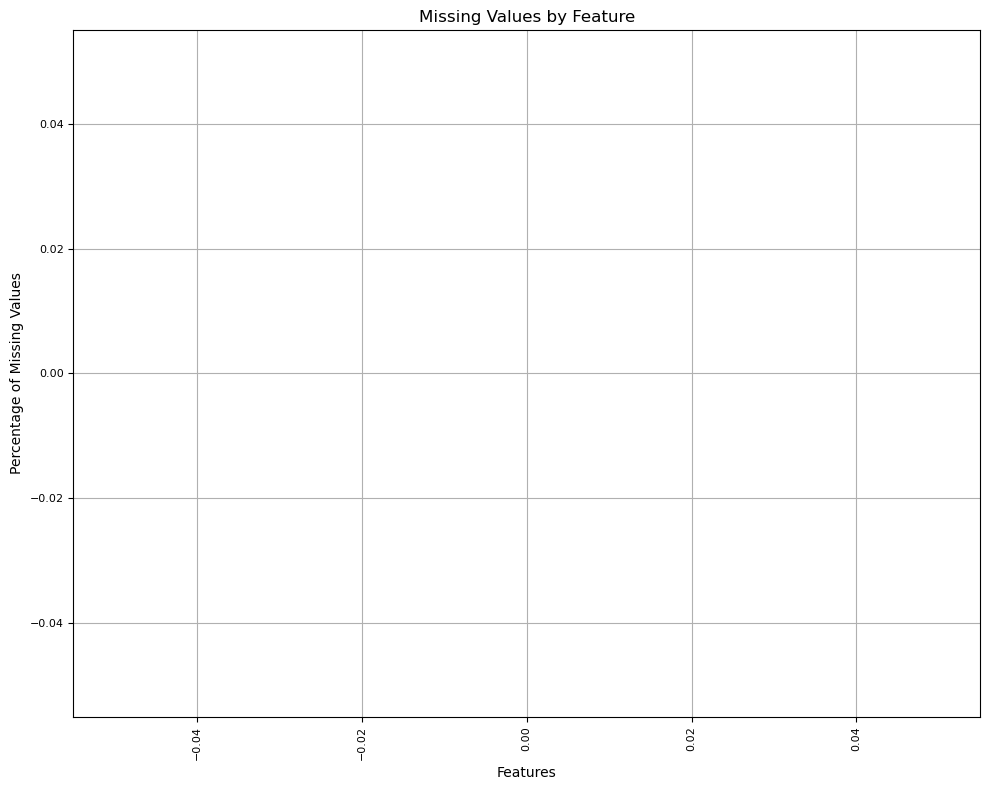

In [20]:
missing_values_table(df, plot=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  object 
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  float64
 6   build_date          21828 non-null  object 
 7   material_type       21828 non-null  object 
 8   remont              21828 non-null  object 
 9   total_balcony       21828 non-null  object 
 10  distance_to_center  21828 non-null  float64
dtypes: float64(5), object(6)
memory usage: 1.8+ MB


# Visualization (graphics) :chart_with_upwards_trend:

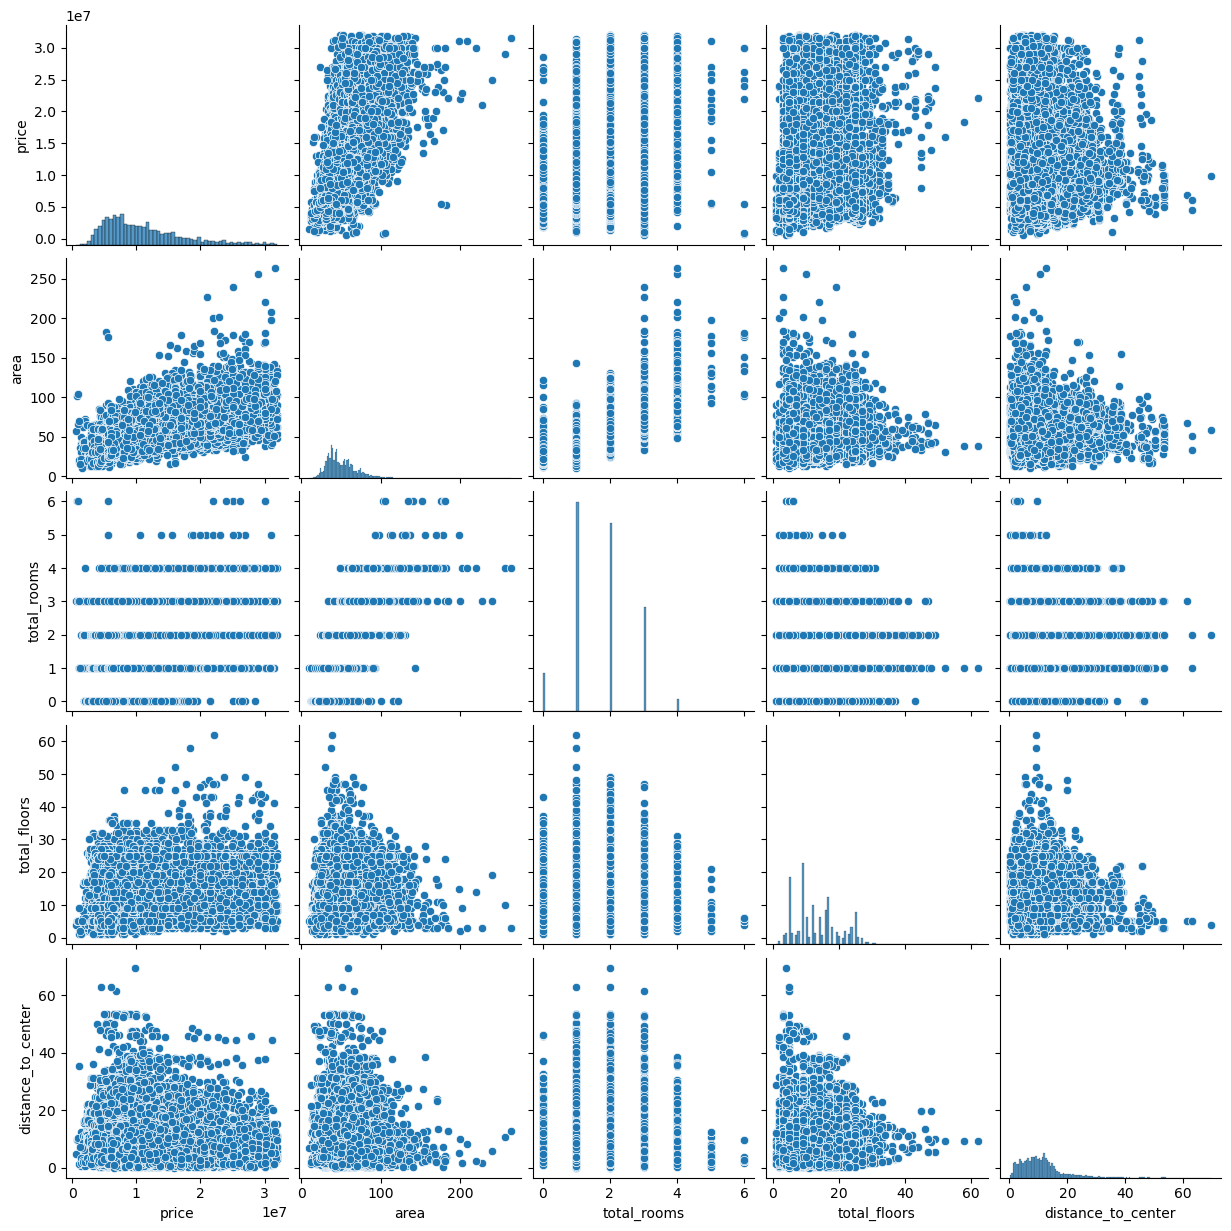

In [22]:
sns.pairplot(df)

In [23]:
count_city = df['city'].value_counts()
count_city

city
Санкт-Петербург    8360
Москва             6113
Новосибирск        2089
Екатеринбург       1152
Балашиха           1008
Геленджик           929
Самара              458
Сочи                407
Казань              403
Анапа               390
Нижний Новгород     268
Краснодар           251
Name: count, dtype: int64

In [24]:
count_type_perec = df['material_type'].value_counts()
count_type_perec

material_type
Монолитный             7558
Панельный              6583
Кирпичный              5359
Монолитно-кирпичный    1361
Блочный                 934
Старый фонд              16
Деревянный               10
Сталинский                7
Name: count, dtype: int64

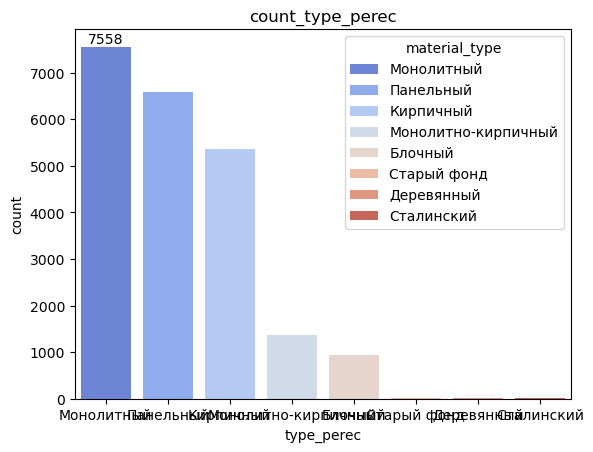

In [25]:
plt.figure()
ax = sns.barplot(x = count_type_perec.index,y = count_type_perec.values, palette='coolwarm', legend=True, hue=count_type_perec.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_type_perec')
plt.xlabel('type_perec')
plt.ylabel('count')
plt.show()

In [26]:
count_remont = df['remont'].value_counts()
count_remont

remont
standard          6038
well_done         5560
empty             5061
without_repair    2616
design            2520
simple              33
Name: count, dtype: int64

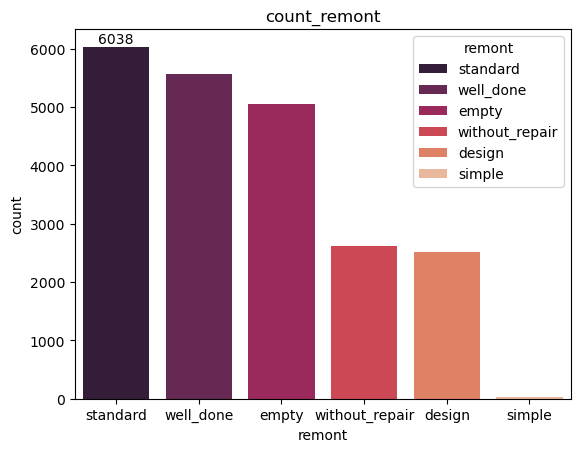

In [27]:
plt.figure()
ax = sns.barplot(x=count_remont.index,y=count_remont.values, palette='rocket', legend=True, hue=count_remont.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_remont')
plt.xlabel('remont')
plt.ylabel('count')
plt.show()

# Fix columns types :wrench:

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  object 
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  float64
 6   build_date          21828 non-null  object 
 7   material_type       21828 non-null  object 
 8   remont              21828 non-null  object 
 9   total_balcony       21828 non-null  object 
 10  distance_to_center  21828 non-null  float64
dtypes: float64(5), object(6)
memory usage: 1.8+ MB


In [29]:
df.kitchen_area = df.kitchen_area.astype('float')
df.total_floors = df.total_floors.astype('int')
df.build_date = df.build_date.astype('float')
df.build_date =  df.build_date.astype('float')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  float64
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  int64  
 6   build_date          21828 non-null  float64
 7   material_type       21828 non-null  object 
 8   remont              21828 non-null  object 
 9   total_balcony       21828 non-null  object 
 10  distance_to_center  21828 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.8+ MB


# :star: Features & Target :dart: 

In [31]:
x = df.drop(columns=['build_date'])
y = df['build_date']

In [32]:
y

0        2013.0
1        2018.0
2        2008.0
3        2017.0
4        2010.0
          ...  
21823    1897.0
21824    1898.0
21825    2021.0
21826    1917.0
21827    2017.0
Name: build_date, Length: 21828, dtype: float64

# :mag: Scaling and split :scissors:

In [33]:
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [34]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                21828 non-null  object 
 1   price               21828 non-null  float64
 2   area                21828 non-null  float64
 3   kitchen_area        21828 non-null  float64
 4   total_rooms         21828 non-null  float64
 5   total_floors        21828 non-null  int64  
 6   material_type       21828 non-null  object 
 7   remont              21828 non-null  object 
 8   total_balcony       21828 non-null  object 
 9   distance_to_center  21828 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.7+ MB


# Teach Models :books:

In [35]:
cb_learn_rate = 0.005
n_iterations = 25000
early_stop_rounds = 400

In [36]:
opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'verbose' : 500,
                       'random_seed' : 42,
                       'cat_features': [0, 6, 7]}

model = CatBoostRegressor(**opt_catboost_params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 24.0418563	test: 24.2426339	best: 24.2426339 (0)	total: 63.8ms	remaining: 26m 34s
500:	learn: 13.0548489	test: 13.0559183	best: 13.0559183 (500)	total: 1.54s	remaining: 1m 15s
1000:	learn: 11.8165755	test: 11.8608053	best: 11.8608053 (1000)	total: 3.05s	remaining: 1m 13s
1500:	learn: 11.2931709	test: 11.4530687	best: 11.4530687 (1500)	total: 4.58s	remaining: 1m 11s
2000:	learn: 10.9259448	test: 11.2018508	best: 11.2018508 (2000)	total: 6.22s	remaining: 1m 11s
2500:	learn: 10.6378810	test: 11.0266117	best: 11.0266117 (2500)	total: 7.89s	remaining: 1m 11s
3000:	learn: 10.4153579	test: 10.8994069	best: 10.8994069 (3000)	total: 9.51s	remaining: 1m 9s
3500:	learn: 10.2236835	test: 10.7947908	best: 10.7947908 (3500)	total: 11.1s	remaining: 1m 8s
4000:	learn: 10.0614177	test: 10.7118667	best: 10.7117394 (3997)	total: 12.7s	remaining: 1m 6s
4500:	learn: 9.9268654	test: 10.6503006	best: 10.6502899 (4499)	total: 14.4s	remaining: 1m 5s
5000:	learn: 9.8000420	test: 10.5992381	best: 10.59

# Test model 

In [37]:
y_pred = model.predict(X_test)
    
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print("Results for CatBoost:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score:", r2)
print()

Results for CatBoost:
Mean Squared Error (MSE): 114.92997114464882
Root Mean Squared Error (RMSE): 10.72053968532596
Mean Absolute Error (MAE): 6.525013381661736
R-squared Score: 0.8116111009382909



# Features importances :star:

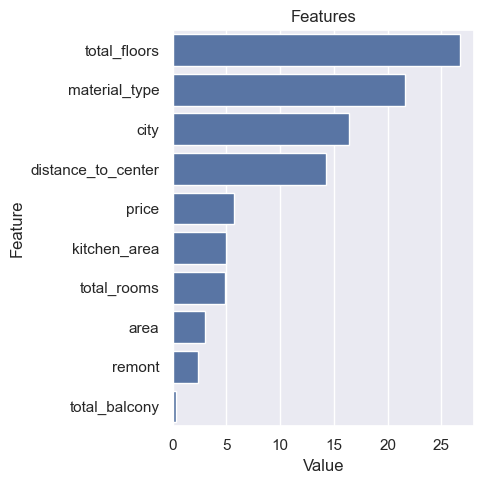

In [38]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(5, 5))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:40])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("../../img/importances.png")

plot_importance(model, X_train, df)

# Save model params :book:

In [39]:
with open('../../models/sigma0-params.json', 'w') as model_params_file:
    json.dump(model.get_all_params(), model_params_file, indent=4)

# Save the best model :floppy_disk:

In [40]:
model_path = "../../models/sigma0.cbm"
model.save_model(model_path)